# Using VGG16 Model and ADAM optimizer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score

In [2]:
# VGG16 is commonly trained on 224x224 images
height = 224
width = 224

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, 3))

In [3]:
train_dir = "dataset/training"
validation_dir = "dataset/validation"
batch_size = 8
num_train_images = 2774
num_validation_images = 592

In [4]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical' # Ensure class_mode is categorical
)

Found 2774 images belonging to 2 classes.


In [5]:
# No augmentation, just preprocessing
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 592 images belonging to 2 classes.


In [6]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    # Freeze the layers of the base model so they are not trained
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for our specific classification task
    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        x = Dense(fc, activation='relu')(x)
        x = Dropout(dropout)(x)

    # Final prediction layer
    predictions = Dense(num_classes, activation='softmax')(x)

    finetune_model = Model(inputs=base_model.input, outputs=predictions)
    return finetune_model

class_list = ['Real', 'Fake']
FC_Layers = [1024, 1024]
dropout = 0.5

In [7]:
finetune_model = build_finetune_model(
    base_model,
    dropout=dropout,
    fc_layers=FC_Layers,
    num_classes=len(class_list)
)

In [8]:
num_epochs = 20

# Callback to save the best model found during training
checkpoint = ModelCheckpoint(
    "VGG16_model_improved.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto'
)

# Callback to stop training early if there's no improvement
early = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=10, # Number of epochs with no improvement to wait before stopping
    verbose=1,
    mode="auto"
)

# Callback to reduce the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,   # Factor by which the learning rate will be reduced
    patience=5,   # Number of epochs with no improvement to wait
    verbose=1,
    min_lr=1e-6 # Lower bound on the learning rate
)

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.001)
finetune_model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=['accuracy']
)

print("Model Summary:")
finetune_model.summary()


Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         2,05

 Total params: 41,457,474 (158.15 MB)

 Trainable params: 26,742,786 (102.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
import pickle

history = finetune_model.fit(
    train_generator,
    steps_per_epoch=num_train_images // batch_size,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=num_validation_images // batch_size,
    callbacks=[checkpoint, early, reduce_lr]
)

with open('vgg16_adam_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

c:\Users\PRATYAOY SARKAR\FinalYrProject\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6633 - loss: 45.1095
Epoch 1: val_accuracy improved from None to 0.77196, saving model to VGG16_model_improved.h5


346/346 ━━━━━━━━━━━━━━━━━━━━ 713s 2s/step - accuracy: 0.7072 - loss: 26.7509 - val_accuracy: 0.7720 - val_loss: 2.3972 - learning_rate: 0.0010
Epoch 2/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 10:50 2s/step - accuracy: 0.8750 - loss: 7.9972

c:\Users\PRATYAOY SARKAR\FinalYrProject\myenv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.77196 to 0.77365, saving model to VGG16_model_improved.h5


346/346 ━━━━━━━━━━━━━━━━━━━━ 93s 265ms/step - accuracy: 0.8750 - loss: 7.9972 - val_accuracy: 0.7736 - val_loss: 2.3710 - learning_rate: 0.0010
Epoch 3/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7918 - loss: 2.8889
Epoch 3: val_accuracy improved from 0.77365 to 0.82432, saving model to VGG16_model_improved.h5


346/346 ━━━━━━━━━━━━━━━━━━━━ 614s 2s/step - accuracy: 0.7892 - loss: 2.3127 - val_accuracy: 0.8243 - val_loss: 1.3882 - learning_rate: 0.0010
Epoch 4/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 8:25 1s/step - accuracy: 0.7500 - loss: 1.2973
Epoch 4: val_accuracy improved from 0.82432 to 0.82770, saving model to VGG16_model_improved.h5


346/346 ━━━━━━━━━━━━━━━━━━━━ 73s 209ms/step - accuracy: 0.7500 - loss: 1.2973 - val_accuracy: 0.8277 - val_loss: 1.3846 - learning_rate: 0.0010
Epoch 5/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.7859 - loss: 1.2016 
Epoch 5: val_accuracy did not improve from 0.82770
346/346 ━━━━━━━━━━━━━━━━━━━━ 4648s 13s/step - accuracy: 0.7719 - loss: 0.9869 - val_accuracy: 0.8193 - val_loss: 0.3778 - learning_rate: 0.0010
Epoch 6/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 7:31 1s/step - accuracy: 1.0000 - loss: 0.1211
Epoch 6: val_accuracy did not improve from 0.82770
346/346 ━━━━━━━━━━━━━━━━━━━━ 80s 229ms/step - accuracy: 1.0000 - loss: 0.1211 - val_accuracy: 0.8209 - val_loss: 0.3922 - learning_rate: 0.0010
Epoch 7/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7523 - loss: 0.6841
Epoch 7: val_accuracy did not improve from 0.82770
346/346 ━━━━━━━━━━━━━━━━━━━━ 584s 2s/step - accuracy: 0.7585 - loss: 0.7173 - val_accuracy: 0.6875 - val_loss: 2.1492 - learning_rate: 0.0010
Epoch 8/20
  1

346/346 ━━━━━━━━━━━━━━━━━━━━ 558s 2s/step - accuracy: 0.7581 - loss: 0.5569 - val_accuracy: 0.8311 - val_loss: 0.3513 - learning_rate: 2.0000e-04
Epoch 12/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 8:43 2s/step - accuracy: 0.8750 - loss: 0.2581
Epoch 12: val_accuracy did not improve from 0.83108
346/346 ━━━━━━━━━━━━━━━━━━━━ 76s 215ms/step - accuracy: 0.8750 - loss: 0.2581 - val_accuracy: 0.8311 - val_loss: 0.3506 - learning_rate: 2.0000e-04
Epoch 13/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7645 - loss: 0.4513
Epoch 13: val_accuracy improved from 0.83108 to 0.86655, saving model to VGG16_model_improved.h5


346/346 ━━━━━━━━━━━━━━━━━━━━ 543s 2s/step - accuracy: 0.7621 - loss: 0.4622 - val_accuracy: 0.8666 - val_loss: 0.3268 - learning_rate: 2.0000e-04
Epoch 14/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 7:27 1s/step - accuracy: 0.6250 - loss: 0.4065
Epoch 14: val_accuracy did not improve from 0.86655
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 192ms/step - accuracy: 0.6250 - loss: 0.4065 - val_accuracy: 0.8581 - val_loss: 0.3308 - learning_rate: 2.0000e-04
Epoch 15/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7909 - loss: 0.4392
Epoch 15: val_accuracy improved from 0.86655 to 0.88851, saving model to VGG16_model_improved.h5


346/346 ━━━━━━━━━━━━━━━━━━━━ 511s 1s/step - accuracy: 0.7849 - loss: 0.4265 - val_accuracy: 0.8885 - val_loss: 0.2536 - learning_rate: 2.0000e-04
Epoch 16/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 8:26 1s/step - accuracy: 0.8750 - loss: 0.3812
Epoch 16: val_accuracy improved from 0.88851 to 0.89189, saving model to VGG16_model_improved.h5


346/346 ━━━━━━━━━━━━━━━━━━━━ 71s 202ms/step - accuracy: 0.8750 - loss: 0.3812 - val_accuracy: 0.8919 - val_loss: 0.2539 - learning_rate: 2.0000e-04
Epoch 17/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7877 - loss: 0.4021
Epoch 17: val_accuracy improved from 0.89189 to 0.91047, saving model to VGG16_model_improved.h5


346/346 ━━━━━━━━━━━━━━━━━━━━ 510s 1s/step - accuracy: 0.8055 - loss: 0.3762 - val_accuracy: 0.9105 - val_loss: 0.2304 - learning_rate: 2.0000e-04
Epoch 18/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 7:01 1s/step - accuracy: 0.8750 - loss: 0.4723
Epoch 18: val_accuracy did not improve from 0.91047
346/346 ━━━━━━━━━━━━━━━━━━━━ 67s 191ms/step - accuracy: 0.8750 - loss: 0.4723 - val_accuracy: 0.9105 - val_loss: 0.2297 - learning_rate: 2.0000e-04
Epoch 19/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8213 - loss: 0.3624
Epoch 19: val_accuracy did not improve from 0.91047
346/346 ━━━━━━━━━━━━━━━━━━━━ 510s 1s/step - accuracy: 0.8275 - loss: 0.3792 - val_accuracy: 0.8919 - val_loss: 0.2552 - learning_rate: 2.0000e-04
Epoch 20/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 7:28 1s/step - accuracy: 0.8750 - loss: 0.1712
Epoch 20: val_accuracy did not improve from 0.91047
346/346 ━━━━━━━━━━━━━━━━━━━━ 68s 194ms/step - accuracy: 0.8750 - loss: 0.1712 - val_accuracy: 0.8902 - val_loss: 0.2526 - learning_rate: 2.000

In [10]:
MODEL_PATH = "VGG16_model_improved.h5"
model = load_model(MODEL_PATH)

# Get true labels
true_labels = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())
predictions = model.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Print final training and validation accuracy from history
train_acc_final = history.history['accuracy'][-1]
val_acc_final = history.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {train_acc_final:.4f}")
print(f"Final Validation Accuracy: {val_acc_final:.4f}")

74/74 ━━━━━━━━━━━━━━━━━━━━ 69s 924ms/step

Final Training Accuracy: 0.8750
Final Validation Accuracy: 0.8902


In [11]:
print("\n--- Model Evaluation Report ---")
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy on Validation Set: {accuracy:.4f}\n")
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))


--- Model Evaluation Report ---
Accuracy on Validation Set: 0.9105

Classification Report:
              precision    recall  f1-score   support

        fake       0.96      0.85      0.91       296
        real       0.87      0.97      0.92       296

    accuracy                           0.91       592
   macro avg       0.92      0.91      0.91       592
weighted avg       0.92      0.91      0.91       592



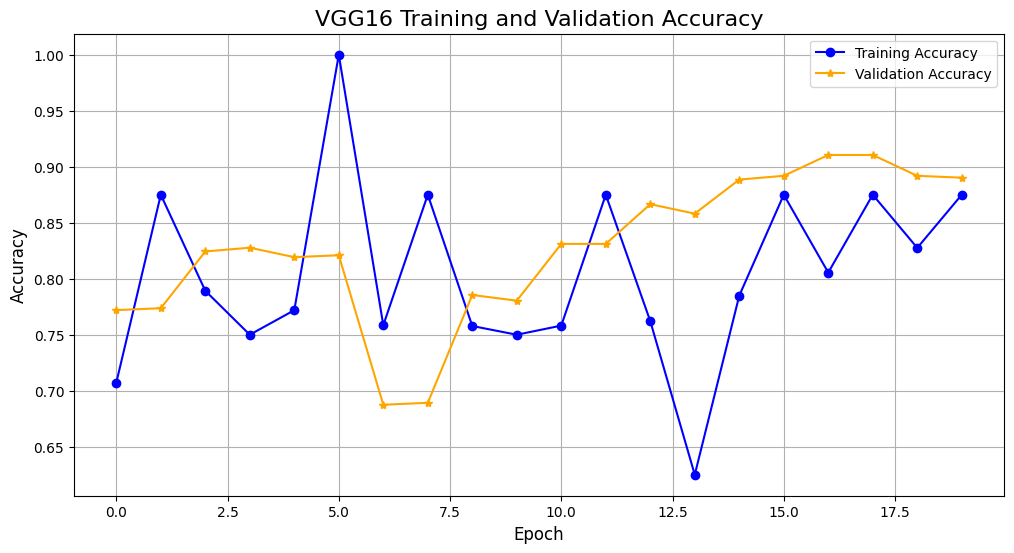

In [12]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Training Accuracy', color='blue', marker='o')
plt.plot(val_acc, label='Validation Accuracy', color='orange', marker='*')
plt.title('VGG16 Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [13]:
from tensorflow.keras.models import load_model
model = load_model("VGG16_model_improved.h5")

with open('vgg16_adam_history.pkl', 'rb') as f:
    history_data = pickle.load(f)

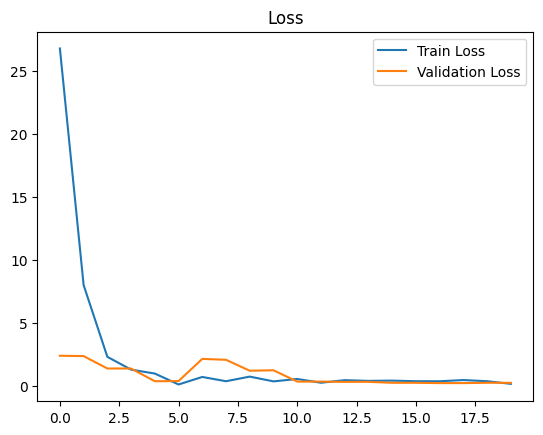

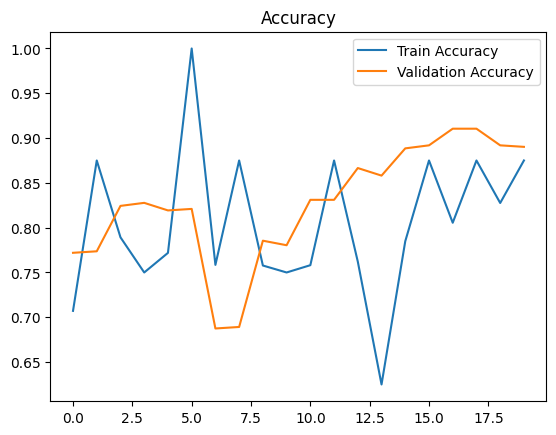

In [14]:
# Loss
plt.plot(history_data['loss'], label='Train Loss')
plt.plot(history_data['val_loss'], label='Validation Loss')
plt.title("Loss")
plt.legend()
plt.show()

# Accuracy
plt.plot(history_data['accuracy'], label='Train Accuracy')
plt.plot(history_data['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy")
plt.legend()
plt.show()

74/74 ━━━━━━━━━━━━━━━━━━━━ 60s 813ms/step


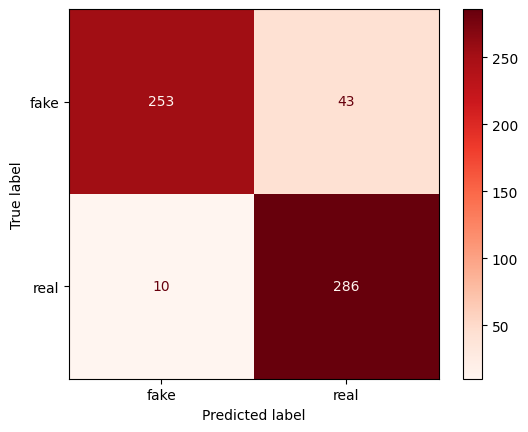

In [17]:
#Confusion Matrix
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = model.predict(validation_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=validation_generator.class_indices)
disp.plot(cmap="Reds")
plt.show()

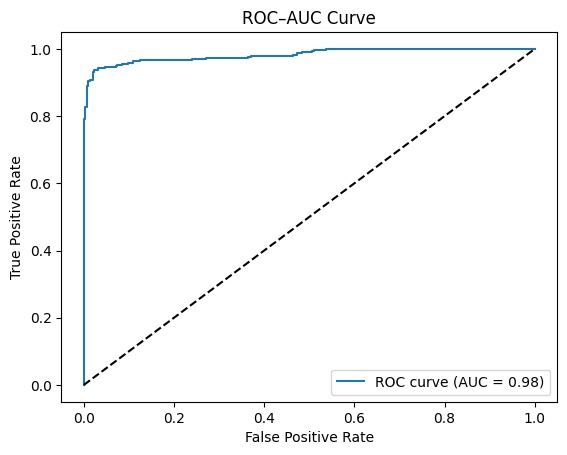

In [18]:
from sklearn.metrics import roc_curve, auc

# take probability of class 1 (real)
y_score = y_pred[:, 1]  
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC–AUC Curve")
plt.legend(loc="lower right")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step


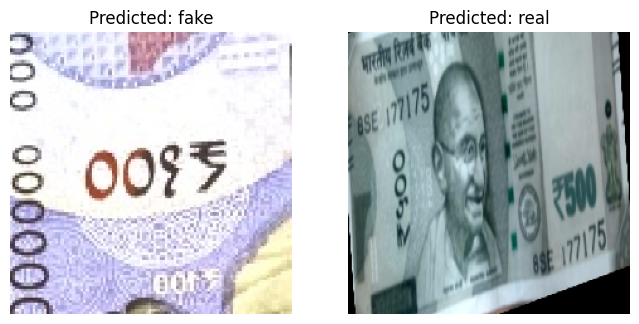

In [21]:
import tensorflow as tf
import numpy as np

img1_path = "dataset/testing/fake/aug_1389_WhatsApp Image 2025-04-05 at 10.59.15.jpeg"
img2_path = "dataset/testing/real/Screenshot 2025-02-11 144137_aug1.jpg"

def preprocess(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=(224,224))
    arr = tf.keras.utils.img_to_array(img)
    arr = np.expand_dims(arr, axis=0) / 255.0
    return img, arr

img1, arr1 = preprocess(img1_path)
img2, arr2 = preprocess(img2_path)

pred1 = np.argmax(model.predict(arr1), axis=1)[0]
pred2 = np.argmax(model.predict(arr2), axis=1)[0]

labels = list(validation_generator.class_indices.keys())

plt.figure(figsize=(8,4))

plt.subplot(1,2,1)
plt.imshow(img1)
plt.title(f"Predicted: {labels[pred1]}")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img2)
plt.title(f"Predicted: {labels[pred2]}")
plt.axis("off")

plt.show()